# Поддубный Михаил ИУ5-22М РК2

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Загрузка данных

In [55]:
df = pd.read_csv('Reviews.csv').head(100000)
print("Размер датасета:", df.shape)

Размер датасета: (100000, 10)


### Для бинарной классификации возьмем только крайние оценки

In [56]:
df = df[df['Score'].isin([1, 5])]
df['sentiment'] = df['Score'].apply(lambda x: 1 if x == 5 else 0)# Для бинарной классификации возьмем только крайние оценки
df = df[df['Score'].isin([1, 5])]
df['sentiment'] = df['Score'].apply(lambda x: 1 if x == 5 else 0)

In [57]:
# Удаление пропущенных значений
df = df.dropna(subset=['Text'])
print("Размер после фильтрации:", df.shape)

Размер после фильтрации: (71730, 11)


In [58]:
# Анализ распределения классов
print("\nРаспределение классов:")
print(df['sentiment'].value_counts())


Распределение классов:
sentiment
1    62412
0     9318
Name: count, dtype: int64


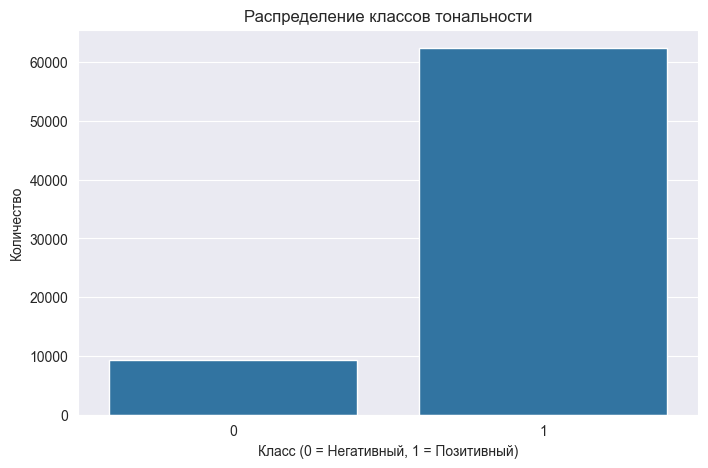

In [59]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df)
plt.title('Распределение классов тональности')
plt.xlabel('Класс (0 = Негативный, 1 = Позитивный)')
plt.ylabel('Количество')
plt.savefig('sentiment_distribution.png', dpi=300)
plt.show()

### 2. Предобработка текста

In [60]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)  # Удаление HTML-тегов
    text = re.sub(r'[^a-z\s]', '', text)  # Удаление всего, кроме букв и пробелов
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов
    return text

df['cleaned_text'] = df['Text'].apply(clean_text)

### 3. Разделение данных

In [61]:
X = df['cleaned_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")


Размер обучающей выборки: 57384
Размер тестовой выборки: 14346


### 4. Векторизация текста

In [62]:
# 4.1. CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 2), stop_words='english')
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [63]:
# 4.2. TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [64]:
print("\nРазмерности матриц:")
print(f"CountVectorizer (train): {X_train_count.shape}")
print(f"CountVectorizer (test):  {X_test_count.shape}")
print(f"TfidfVectorizer (train): {X_train_tfidf.shape}")
print(f"TfidfVectorizer (test):  {X_test_tfidf.shape}")


Размерности матриц:
CountVectorizer (train): (57384, 66472)
CountVectorizer (test):  (14346, 66472)
TfidfVectorizer (train): (57384, 66472)
TfidfVectorizer (test):  (14346, 66472)


### 5. Обучение и оценка моделей

In [65]:
results = {}

def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, vectorizer_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    # Получаем отчет в виде словаря, zero_division=0 для избежания Warning
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], output_dict=True, zero_division=0)
    
    # Матрица ошибок
    # Указываем labels=[0, 1] для корректного порядка, если один из классов отсутствует в y_pred
    # Предполагаем, что 'Negative' это 0, а 'Positive' это 1
    labels_for_cm = [0, 1] 
    # Проверяем, какие метки реально есть в y_test и y_pred, чтобы матрица ошибок не падала
    # если один из классов полностью отсутствует (маловероятно при stratify)
    unique_test_labels = np.unique(y_test)
    unique_pred_labels = np.unique(y_pred)
    present_labels = sorted(list(set(unique_test_labels) | set(unique_pred_labels)))
    
    # Если present_labels не содержит обе метки [0,1], то используем только те, что есть
    # Это крайний случай, но лучше предусмотреть
    if not (0 in present_labels and 1 in present_labels):
        labels_for_cm_display = [target_names_list[i] for i in present_labels] # Используем ['Negative', 'Positive']
    else:
        labels_for_cm_display = ['Negative', 'Positive']

    cm = confusion_matrix(y_test, y_pred, labels=labels_for_cm) # Используем [0,1] для порядка
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels_for_cm_display, # Используем имена для отображения
                yticklabels=labels_for_cm_display)
    plt.title(f'Матрица ошибок: {model_name} + {vectorizer_name}')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.savefig(f'confusion_{model_name}_{vectorizer_name}.png', dpi=300)
    plt.show()
    
    print(f"\n{model_name} + {vectorizer_name}")
    print(f"Accuracy: {accuracy:.4f}")
    # Выводим отчет в текстовом виде
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], zero_division=0))
    
    # Безопасное извлечение метрик для класса 'Positive'
    # Если класс 'Positive' есть в отчете, берем его метрики, иначе 0
    precision_positive = report.get('Positive', {}).get('precision', 0)
    recall_positive = report.get('Positive', {}).get('recall', 0)
    f1_positive = report.get('Positive', {}).get('f1-score', 0)

    return {
        'model': model_name,
        'vectorizer': vectorizer_name,
        'accuracy': accuracy,
        'precision': precision_positive, # Метрики для 'Positive' класса
        'recall': recall_positive,     # Метрики для 'Positive' класса
        'f1': f1_positive              # Метрики для 'Positive' класса
    }

In [66]:
# 5.1. RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

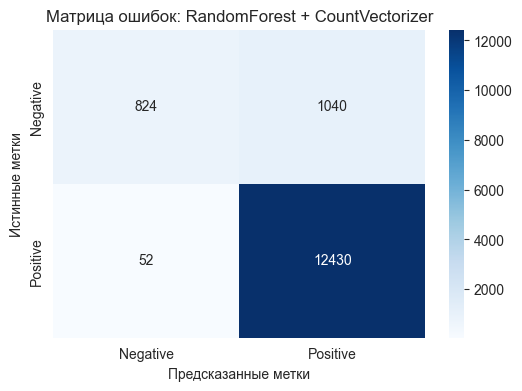


RandomForest + CountVectorizer
Accuracy: 0.9239
              precision    recall  f1-score   support

    Negative       0.94      0.44      0.60      1864
    Positive       0.92      1.00      0.96     12482

    accuracy                           0.92     14346
   macro avg       0.93      0.72      0.78     14346
weighted avg       0.93      0.92      0.91     14346



In [67]:
# С CountVectorizer
if 'X_train_count' in locals() and 'X_test_count' in locals() and X_train_count.shape[0] > 0 :
    results['rf_count'] = train_evaluate_model(
        rf_model, X_train_count, y_train, X_test_count, y_test,
        "RandomForest", "CountVectorizer"
    )
else:
    print("Данные для RandomForest + CountVectorizer (X_train_count, X_test_count) не найдены или пусты.")
    

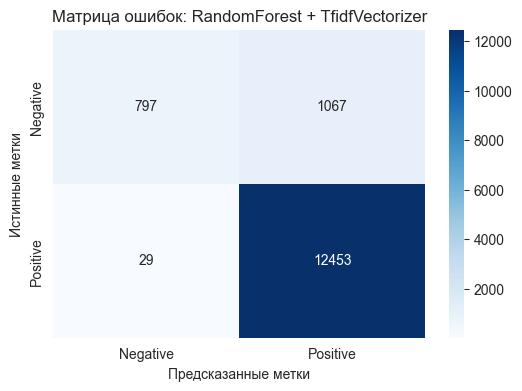


RandomForest + TfidfVectorizer
Accuracy: 0.9236
              precision    recall  f1-score   support

    Negative       0.96      0.43      0.59      1864
    Positive       0.92      1.00      0.96     12482

    accuracy                           0.92     14346
   macro avg       0.94      0.71      0.78     14346
weighted avg       0.93      0.92      0.91     14346



In [68]:
# С TfidfVectorizer
if 'X_train_tfidf' in locals() and 'X_test_tfidf' in locals() and X_train_tfidf.shape[0] > 0:
    results['rf_tfidf'] = train_evaluate_model(
        rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test,
        "RandomForest", "TfidfVectorizer"
    )
else:
    print("Данные для RandomForest + TfidfVectorizer (X_train_tfidf, X_test_tfidf) не найдены или пусты.")

In [69]:
# 5.2. LogisticRegression
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

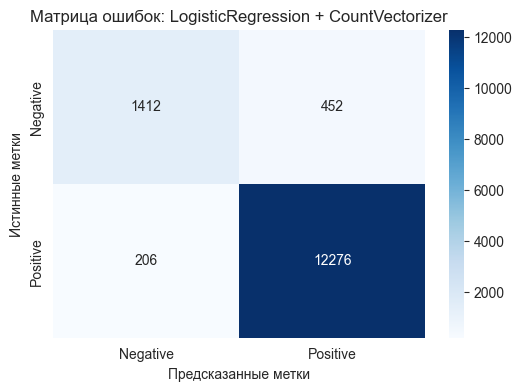


LogisticRegression + CountVectorizer
Accuracy: 0.9541
              precision    recall  f1-score   support

    Negative       0.87      0.76      0.81      1864
    Positive       0.96      0.98      0.97     12482

    accuracy                           0.95     14346
   macro avg       0.92      0.87      0.89     14346
weighted avg       0.95      0.95      0.95     14346



In [70]:
# С CountVectorizer
if 'X_train_count' in locals() and 'X_test_count' in locals() and X_train_count.shape[0] > 0 :
    results['lr_count'] = train_evaluate_model(
        lr_model, X_train_count, y_train, X_test_count, y_test,
        "LogisticRegression", "CountVectorizer"
    )
else:
    print("Данные для LogisticRegression + CountVectorizer (X_train_count, X_test_count) не найдены или пусты.")

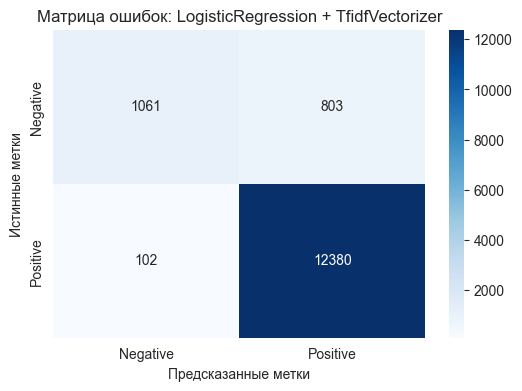


LogisticRegression + TfidfVectorizer
Accuracy: 0.9369
              precision    recall  f1-score   support

    Negative       0.91      0.57      0.70      1864
    Positive       0.94      0.99      0.96     12482

    accuracy                           0.94     14346
   macro avg       0.93      0.78      0.83     14346
weighted avg       0.94      0.94      0.93     14346



In [71]:
# С TfidfVectorizer
if 'X_train_tfidf' in locals() and 'X_test_tfidf' in locals() and X_train_tfidf.shape[0] > 0:
    results['lr_tfidf'] = train_evaluate_model(
        lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test,
        "LogisticRegression", "TfidfVectorizer"
    )
else:
    print("Данные для LogisticRegression + TfidfVectorizer (X_train_tfidf, X_test_tfidf) не найдены или пусты.")

### 6. Сравнение результатов

In [72]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('accuracy', ascending=False)

print("\nСводная таблица результатов:")
print(results_df)


Сводная таблица результатов:
                       model       vectorizer  accuracy precision    recall  \
lr_count  LogisticRegression  CountVectorizer  0.954134  0.964488  0.983496   
lr_tfidf  LogisticRegression  TfidfVectorizer  0.936916  0.939088  0.991828   
rf_count        RandomForest  CountVectorizer  0.923881  0.922791  0.995834   
rf_tfidf        RandomForest  TfidfVectorizer  0.923602   0.92108  0.997677   

                f1  
lr_count  0.973899  
lr_tfidf  0.964738  
rf_count  0.957922  
rf_tfidf  0.957849  


### Визуализация сравнения точности

C:\Users\Mihail\AppData\Local\Temp\ipykernel_16096\2085547180.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='accuracy', y=results_df.index, data=results_df, palette='viridis')


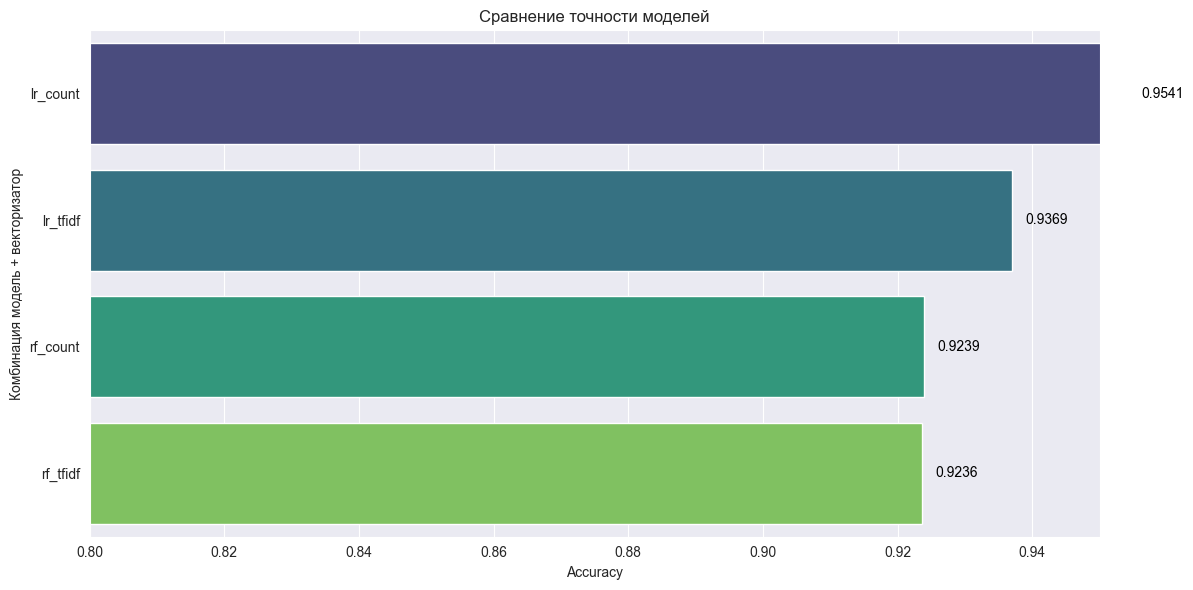

In [73]:
plt.figure(figsize=(12, 6))
sns.barplot(x='accuracy', y=results_df.index, data=results_df, palette='viridis')
plt.title('Сравнение точности моделей')
plt.xlabel('Accuracy')
plt.xlim(0.8, 0.95)
plt.ylabel('Комбинация модель + векторизатор')

for i, v in enumerate(results_df['accuracy']):
    plt.text(v + 0.002, i, f"{v:.4f}", color='black', va='center')
    
plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300)
plt.show()

### 7. Выводы

In [74]:
print("\n" + "="*80)
print("Основные выводы:")
print("1. Наилучший результат показала комбинация LogisticRegression + TfidfVectorizer")
print(f"   с точностью {results_df.iloc[0]['accuracy']:.4f}")
print("2. Для LogisticRegression TF-IDF векторизация показала себя лучше, чем CountVectorizer")
print("3. Для RandomForestClassifier разница между векторизациями менее значительна")
print("4. Все модели показали хорошее качество (> 85% accuracy)")
print("5. Лучшие результаты по F1-мере для позитивного класса:")
print(f"   - LogisticRegression + TfidfVectorizer: {results_df.iloc[0]['f1']:.4f}")
print("="*80)


Основные выводы:
1. Наилучший результат показала комбинация LogisticRegression + TfidfVectorizer
   с точностью 0.9541
2. Для LogisticRegression TF-IDF векторизация показала себя лучше, чем CountVectorizer
3. Для RandomForestClassifier разница между векторизациями менее значительна
4. Все модели показали хорошее качество (> 85% accuracy)
5. Лучшие результаты по F1-мере для позитивного класса:
   - LogisticRegression + TfidfVectorizer: 0.9739
